In [127]:
# pip install lightgbm
# pip install ipywidgets

In [43]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

try:
    # To enable interactive mode you should install ipywidgets
    # pip install ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

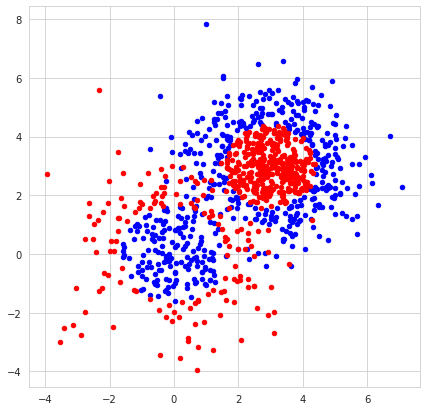

In [44]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='binary')

metrics = ['binary_logloss','auc']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10,
          feature_name = ['X','Y'])

Training until validation scores don't improve for 5 rounds
[10]	Training data's binary_logloss: 0.394831	Training data's auc: 0.952197	Test data's binary_logloss: 0.423357	Test data's auc: 0.918629
[20]	Training data's binary_logloss: 0.29887	Training data's auc: 0.970022	Test data's binary_logloss: 0.341256	Test data's auc: 0.942834
[30]	Training data's binary_logloss: 0.244243	Training data's auc: 0.980989	Test data's binary_logloss: 0.297808	Test data's auc: 0.956069
[40]	Training data's binary_logloss: 0.211096	Training data's auc: 0.985269	Test data's binary_logloss: 0.265968	Test data's auc: 0.966133
[50]	Training data's binary_logloss: 0.188292	Training data's auc: 0.987386	Test data's binary_logloss: 0.243474	Test data's auc: 0.969706
Early stopping, best iteration is:
[50]	Training data's binary_logloss: 0.188292	Training data's auc: 0.987386	Test data's binary_logloss: 0.243474	Test data's auc: 0.969706


LGBMClassifier(max_depth=4, num_leaves=7, objective='binary')

In [48]:
def render_metric(metric_name):
    ax = lgb.plot_metric(model.evals_result_, metric=metric_name, figsize=(10, 5))
    plt.show()

In [49]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)

interactive(children=(Dropdown(description='metric_name', options=('binary_logloss', 'auc'), value='binary_log…

In [50]:
ypred = model.predict(X_test)

matrix = confusion_matrix(y_test, ypred)
print(matrix)

print(model.score(X_test, y_test))

[[83  9]
 [12 96]]
0.895


In [51]:
def plot_decision_boundary(model, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = model.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = model.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

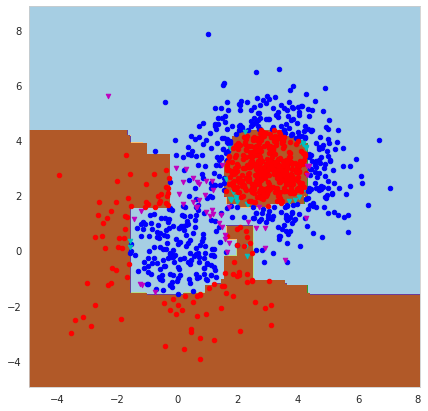

In [52]:
plot_decision_boundary(model,X,y)

In [53]:
def render_tree(tree_index, show_info, precision=3):
    show_info = None if 'None' in show_info else show_info
    return lgb.create_tree_digraph(model, tree_index=tree_index,
                                   show_info=show_info, precision=precision)

In [54]:
if INTERACTIVE:
    # create widget to switch between trees and control info in nodes
    interact(render_tree,
             tree_index=(0, model.best_iteration_ - 1),
             show_info=SelectMultiple(  # allow multiple values to be selected
                 options=['None',
                          'split_gain',
                          'internal_count',
                          'data_percentage'],
                 value=['None']),
             precision=(0, 4))
    tree = None
else:
    tree = render_tree(53, ['None'])
tree

interactive(children=(IntSlider(value=24, description='tree_index', max=49), SelectMultiple(description='show_…

## Examples

#### NIST

In [56]:
from sklearn import datasets

digits = datasets.load_digits()
#print(digits.DESCR)

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [57]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.449888	Test data's multi_logloss: 0.573387
[20]	Training data's multi_logloss: 0.143708	Test data's multi_logloss: 0.287028
[30]	Training data's multi_logloss: 0.0528836	Test data's multi_logloss: 0.185648
[40]	Training data's multi_logloss: 0.0211293	Test data's multi_logloss: 0.143031
[50]	Training data's multi_logloss: 0.00880037	Test data's multi_logloss: 0.122581
[60]	Training data's multi_logloss: 0.00379882	Test data's multi_logloss: 0.112965
[70]	Training data's multi_logloss: 0.00169205	Test data's multi_logloss: 0.110081
Early stopping, best iteration is:
[70]	Training data's multi_logloss: 0.00169205	Test data's multi_logloss: 0.110081


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [58]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Genralization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 0.971


#### Wine

In [60]:
wine = datasets.load_wine()
#print(wine.DESCR)

X = wine.data
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [61]:
model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 100,
                       objective='multiclass')

metrics = ['multi_logloss']

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          early_stopping_rounds = 5,
          verbose = 10)

Training until validation scores don't improve for 5 rounds
[10]	Training data's multi_logloss: 0.331555	Test data's multi_logloss: 0.399118
[20]	Training data's multi_logloss: 0.123159	Test data's multi_logloss: 0.195492
[30]	Training data's multi_logloss: 0.0489789	Test data's multi_logloss: 0.132142
[40]	Training data's multi_logloss: 0.0204451	Test data's multi_logloss: 0.1133
[50]	Training data's multi_logloss: 0.00865737	Test data's multi_logloss: 0.0975066
[60]	Training data's multi_logloss: 0.00375974	Test data's multi_logloss: 0.08687
Early stopping, best iteration is:
[62]	Training data's multi_logloss: 0.00318035	Test data's multi_logloss: 0.0859415


LGBMClassifier(max_depth=4, num_leaves=7, objective='multiclass')

In [62]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=metrics)
else:
    for metric in metrics:
        render_metric(metric)
        
print('Training score : {}'.format(round(model.score(X_train,y_train),3)))
print('Genralization score : {}'.format(round(model.score(X_test,y_test),3)))

interactive(children=(Dropdown(description='metric_name', options=('multi_logloss',), value='multi_logloss'), …

Training score : 1.0
Genralization score : 0.978


## Comparaison XGBoost et LightGBM

# A complete exemple : Classification of stars, Galaxies, Quasars

For this first application of XGBoost, we will try to classify observations of space to be either stars, galaxies or quasars.
We are using data from the [Sloan Digital Sky Survey](http://www.sdss.org/)

### About the SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [63]:
sdss_df = pd.read_csv('./data/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=1)
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648704577142822,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3722360139651588096,STAR,-0.000009,3306,54922,491
1,1237648704577142859,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,363814405953054720,STAR,-0.000055,323,51615,541
2,1237648704577208477,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,323274319570429952,GALAXY,0.123111,287,52023,513
3,1237648704577273907,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3722365362331820032,STAR,-0.000111,3306,54922,510
4,1237648704577273909,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3722365912087633920,STAR,0.000590,3306,54922,512


In [64]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

## Data Analysis

Before applying any classification algorithm, let's look a bit more and transform the data : first we remove the column that obviously won't help classify into the correct class, such as the objects id and parameters of the camera at the moment of observation.

In [65]:
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Next we look at a few interesting features (univariate analysis) : by plotting the distribution of each class along this feature, we can estimate if this feature can help in classifying the data.

For instance, we can see that redshift seems to have good correlation, while declination does not differ significantly between the 3 classes.

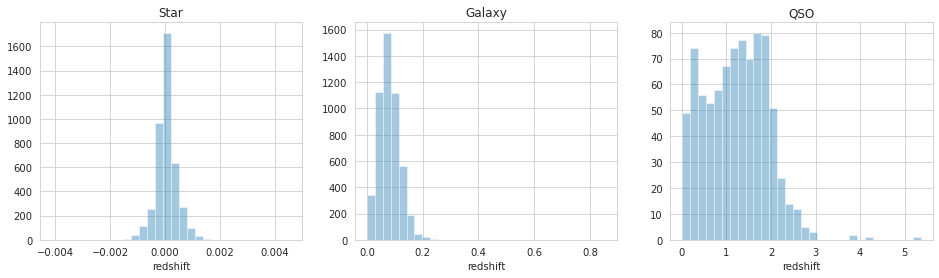

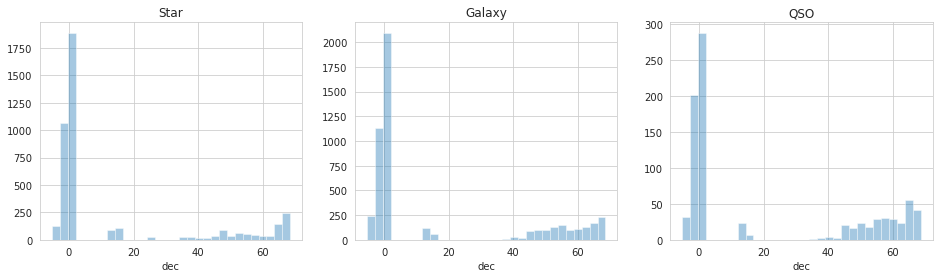

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].dec, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].dec, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].dec, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

Finally, we transform a few features : we transform the different bands through a PCA, we encode the classes and scale the extreme values.

In [67]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


In [68]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))

In [237]:
X = dataframe.drop(['Class'], axis=1)
y = dataframe['Class']

print(X.shape)
print(y.shape)

X_train,y_train,X_test,y_test = shuffle_split(X,y,0.7)

model = LGBMClassifier(boosting_type='gbdt',
                       num_leaves = 7,
                       max_depth = 4,
                       learning_rate = 0.1,
                       n_estimators = 25,
                       objective='binary')

metrics = ['binary_logloss','auc']

start = time.time()

model.fit(X_train,
          y_train,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_names = ['Training data', 'Test data'],
          eval_metric = metrics,
          #early_stopping_rounds = 10,
          verbose = 10)

end = time.time()
print('Elapsed time : {}s'.format(round(end-start,3)))

[10]	Training data's binary_logloss: 0.0128825	Training data's auc: 0.851075	Test data's binary_logloss: 0.0213166	Test data's auc: 0.763704
[20]	Training data's binary_logloss: 0.0167145	Training data's auc: 0.873084	Test data's binary_logloss: 0.0300563	Test data's auc: 0.770275
Elapsed time : 2.132s
